# Imports

We first plot the trial matrixes that were generated during data collection

In [1]:
%load_ext autoreload
%autoreload 2

%run ../../setup_project.py
%run ../../generic_plot_functions.py

warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
projectName, dataPath, dlcModelPath, myProject, sSessions= setup_project_session_lists(projectName="autopi_mec",dataPath=PROJECT_DATA_PATH,dlcModelPath="")

creating myProject, an autopipy.project object
Project name: autopi_mec
dataPath: /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt/
dlcModelPath: 
Reading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


# Data prep

In [3]:
fn=myProject.dataPath+"/results/searchIFRDict.pickle"
print("Loading:",fn)
with open(fn, 'rb') as handle:
    searchIFR = pickle.load(handle)
    
# matrices with single trials 
fn=myProject.dataPath+"/results/homingIFRDict.pickle"
print("loading:",fn)
with open(fn, 'rb') as handle:
    homingIFR = pickle.load(handle)

Loading: /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//results/searchIFRDict.pickle
loading: /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//results/homingIFRDict.pickle


In [4]:
fn = myProject.dataPath+"/results/myMaps.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
    myMaps = pickle.load(handle)

In [5]:
fn=myProject.dataPath+"/results/cells.csv"
cells = pd.read_csv(fn)

In [6]:
fn = myProject.dataPath+"/results/myLeverMaps.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
   myLeverMaps = pickle.load(handle)

In [7]:
# Boxplot kwargs
boxprops = {"edgecolor": "k", "linewidth": 1.5}
lineprops = {"color": "k", "linewidth": 1.5}
histprops = {"linewidth": 1.5}
arrowParams = {"headwidth": 4, "headlength": 6, "headaxislength": 5.5}

boxplot_kwargs = dict(
    {
        "boxprops": boxprops,
        "medianprops": lineprops,
        "whiskerprops": lineprops,
        "capprops": lineprops,
    }
)  #'width': 0.75
stripplot_kwargs = dict(
    {"linewidth": 1, "size": 5, "alpha": 0.8},
)

GLOBALFONTSIZE = 12

# Plot trial matrix maps

In [8]:
from statannotations.Annotator import Annotator

In [9]:
gridCellList = cells[cells.usable & cells.gridCell_FIRST].cluId.unique()

In [10]:
mySearchDict={}
for oneId in searchIFR.keys():
    if oneId in list(gridCellList):
        mySearchDict.update({oneId:searchIFR[oneId]})
print(len(mySearchDict.keys()))

931


In [11]:
myHomingDict={}
for oneId in homingIFR.keys():
    if oneId in list(gridCellList):
        myHomingDict.update({oneId:homingIFR[oneId]})
print(len(myHomingDict.keys()))

931


# Processing functions

In [12]:
def get_lever_y_sort_order(cluId,condition):
    cluNo = cluId.split("_")[1]
    session = cluId.split("_")[0]
   
    sSes = [sSes for sSes in sSessions if sSes.name == session][0]
    ses = myProject.getSession(session)
    
    load_spikeA_one_session(sSes)


    fn=ses.path+"/ses.pickle"
    with open(fn, 'rb') as handle:
        ses=pickle.load(handle)

    getSearchHomingIntervals(ses,sSes)
        
    
    ifr, navs, inav = load_ifr_behavior(ses)
    
    sSes.ap.set_intervals(ses.intervalDict[condition])
    
    pathType = condition.split("_")[0]
    light = condition.split("_")[1]
    
    trialNos = navs[(navs.type==pathType) & (navs.nLeverPresses >= 1) & (navs.light==light)].trialNo
    leverYs = [ ses.trialList[tn-1].lever.leverCenter[1]  for tn in trialNos] 
    
    lev = np.array(leverYs)
    
    argSort = lev.argsort()
    
    return argSort

In [13]:
def plotTrialIFRMatrix(ax,matDict,showXLabel=True,sort=False, showYLabel=True,colorBar=False,aspect="auto",process=False):
    """
    Plot the matrix of rate per journey as a function ?
    """
    if "matrix" not in matDict.keys():
        print("matrix key missing")
        
    mD = matDict.copy()
    
    bins = mD["bins"]
    ld = mD["light"]
    pathType = mD["pathType"]
    condition = pathType+'_'+ld
    cluId = mD["cluId"]
    
    
    
    xLabelsDict = {"y":"Y position (cm)",
                   "iTime": "Time (sec)",
                   "distance": "Distance run (cm)",
                   "targetDistance": "Lever distance (cm)"}
    
    if sort:
            oM= mD["matrix"][np.argsort(-np.sum(np.isnan(mD["matrix"]),axis=1))].copy()
            mD["matrix"] = oM
        
    if process:
        mD = removeEmptyTrials(mD)
        mD = trimTrailingMatrixNanColumn(mD)
        mD = cutExtremelyLongTrials(mD)
        mD = removeEmptyColumnsAtBeginning(mD)
    
    m = mD["matrix"]
        
    pos = ax.imshow(m,aspect=aspect,interpolation="none",origin="lower",cmap="viridis",
                   extent=[np.min(bins),np.max(bins),0,m.shape[0]])
    if colorBar:
        fig.colorbar(pos, ax=ax)
    
    if showYLabel:
        ax.set_ylabel("Paths")
    if showXLabel:
        ax.set_xlabel(xLabelsDict[mD["var"]],fontsize=GLOBALFONTSIZE-2,fontweight='bold')
        ax.xaxis.set_label_coords(0.5,-0.175)
    else:
        ax.set_xlabel([])
        

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return m

In [14]:
def trimTrailingMatrixNanColumn(matDict):
    """
    Removes columns of the matrix that are filled with np.nan. 
    Only removes columns that are after the last column containing valid values
    """
    if "matrix" not in matDict.keys():
        print("matrix key missing")
    
    m = matDict["matrix"]
    bins = matDict["bins"]
    
    nRows = m.shape[0]
    nCols = m.shape[1]
    emptyCol = np.sum(np.isnan(m),axis=0) == nRows
    if np.sum(emptyCol) > 0:
        lastNotEmpty = np.max(np.where(emptyCol==0))
        m = m[:,:lastNotEmpty+1]
        bins = bins[:lastNotEmpty+2]
    
    matDict["matrix"] = m
    matDict["bins"] = bins
    
    #print("trim",matDict["matrix"].shape,matDict["bins"].shape)
    return matDict
    
def removeEmptyTrials(matDict):
    """
    Remove any trials that have only np.nan values
    """
    if "matrix" not in matDict.keys():
        print("matrix key missing")    
    m = matDict["matrix"]
    matDict["matrix"] = m[np.sum(~np.isnan(m),axis=1)>0,:]
    #print("removeEmpyt",matDict["matrix"].shape,matDict["bins"].shape)
    return matDict
    
    
def cutExtremelyLongTrials(matDict, minNumberValidValues=10):
    """
    Identify the longest trials of the session and remove the values at the end so that there is at least minNumberValidValues in each column of the matrix
    
    This was implemented to prevent that a single very long trial compromise the detection of the peak firing rate location calculated from all trials. 
    
    This procedure makes sure that one spike in a very long path will not be detected as the peak location in the matrix. Each value will be the average of a few trials.
    
    """
    if "matrix" not in matDict.keys():
        print("matrix key missing")    
    m = matDict["matrix"]
    bins = matDict["bins"]
    
    def myFct(x):
        if np.sum(x)> 0:
            return np.max(np.where(x))
        else:
            return x.shape[0]
    lastValidValueInRow = np.apply_along_axis(myFct, axis=1,arr = ~np.isnan(m))
    sortedValid = np.sort(lastValidValueInRow)
    threshold = sortedValid[-minNumberValidValues]
    
    matDict["matrix"] = m[:,:threshold+1]
    matDict["bins"] = bins[:threshold+2]
    #print("cutExtremelyLong",matDict["matrix"].shape,matDict["bins"].shape)
    return matDict

def removeEmptyColumnsAtBeginning(matDict,minNumberValidValues=10):
    """
    Check if there are empty columns at the left side of the matrix or if there are some that have fewer than minNumberValidValues, if so remove them.
    
    It will stop removing as soon as there is a column with the minNumberValidValues
    
    """
    if "matrix" not in matDict.keys():
        print("matrix key missing")    
    m = matDict["matrix"]
    bins = matDict["bins"]
    
    def myFct(x):
        if np.sum(x)>0:
            return np.min(np.where(x))
        else:
            return 0
    firstValidValueInRow = np.apply_along_axis(myFct, axis=1,arr = ~np.isnan(m))
    
    sortedValid = np.sort(firstValidValueInRow)
    threshold = sortedValid[minNumberValidValues]
    
    matDict["matrix"] = m[:,threshold:]
    matDict["bins"] = bins[(threshold):]
    #print("removeEmptyColumns",matDict["matrix"].shape,matDict["bins"].shape)
    return matDict

In [15]:
import re

def add_trialNo_to_matrix(mainDict,cluId,pathType,light,var):
    matDic = mainDict[cluId]["matrix"]["{}_{}_{}".format(pathType,light,var)]
    
    # Add trial number
    trial_numbers = [int(re.search(r'_(\d+)-', name).group(1)) for name in matDic["names"]]
    matDic['trialNo'] = trial_numbers
    
    return matDic

def get_matDic(mainDict,cluId,pathType,light,var):
    """
    get a dictionary with one matrix, bins, and other variables from the dictionary containing all neurons, all conditions
    
    We set a few keys in the dictionary that can be used when ploting and processing.
    """
    matDic = mainDict[cluId]["matrix"]["{}_{}_{}".format(pathType,light,var)]
    matDic["pathType"] = pathType
    matDic["light"] = light
    matDic["var"] = var
    matDic["cluId"] = cluId
    
    # Add trial number
    trial_numbers = [int(re.search(r'_(\d+)-', name).group(1)) for name in matDic["names"]]
    matDic['trialNo'] = trial_numbers
    
    return matDic

In [16]:
from scipy.stats import skew

def trialMatrixDescriptiveStats(mDict):
    """
    Function that calculate statistics that describe a trial matrix
    """
    #print(matDict["cluId"],matDict["pathType"],matDict["light"],matDict["var"])
    matDict = mDict.copy()
    matDict = trimTrailingMatrixNanColumn(matDict)
    matDict = removeEmptyTrials(matDict)
    matDict = cutExtremelyLongTrials(matDict,minNumberValidValues=10)
    
    m = matDict["matrix"]
    bins = matDict["bins"]
    steps = bins[1]-bins[0]
    midBins = bins[:-1]+steps/2
    
    
    meanRate = np.nanmean(m)
    maxRate = np.nanmax(m)
    meanRateHisto = np.nanmean(m,axis = 0)
    #print(meanRateHisto)
    maxRateInHisto = np.nanmax(meanRateHisto)
    maxRateInHistoIndex = np.argmax(meanRateHisto)
    maxRateInHistoLoc = midBins[maxRateInHistoIndex]
    stdAtPeak = np.nanstd(m[:,maxRateInHistoIndex])
    # calculate the skewness of the rate values in the matrix, matrix with a clear peak with have a high sckewness
    a = m.reshape((1,-1))
    a = a [~np.isnan(a)]
    rateSkew = skew(a)
    return pd.DataFrame({"cluId": matDict["cluId"],
                         "pathType": matDict["pathType"],
                         "light": matDict["light"],
                         "behavioralVariable": matDict["var"],
                         "meanRate":[meanRate],
                         "maxRate":maxRate, 
                         "maxRateInHisto":maxRateInHisto, 
                         "maxRateInHistoLoc":maxRateInHistoLoc, 
                         "stdAtPeak":stdAtPeak, 
                         "rateSkew":rateSkew})

In [17]:
cluId1 = 'jp3269-28112022-0108_52'
cluId2 = 'jp486-24032023-0108_490'

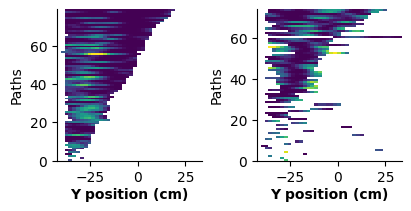

In [18]:
m1 = get_matDic(myHomingDict,cluId=cluId1,pathType = "homingFromLeavingLeverToPeriphery", light = "light", var = "y") 
m2 = get_matDic(myHomingDict,cluId=cluId1,pathType = "homingFromLeavingLeverToPeriphery", light = "dark", var = "y")

nRows=1
nCols=2
axesRowSize,axesColSize = 2,2
fig = plt.figure(figsize=(nCols*axesColSize,nRows*axesRowSize), constrained_layout=True) # figsize = (width,height)
spec = fig.add_gridspec(nrows=nRows,ncols=nCols) # create a GridSpec object to a figure

ax = fig.add_subplot(spec[0])  
oM1 = plotTrialIFRMatrix(ax,m1,sort=True,process=False)

ax = fig.add_subplot(spec[1])
oM2 = plotTrialIFRMatrix(ax,m2,sort=True,process=False)

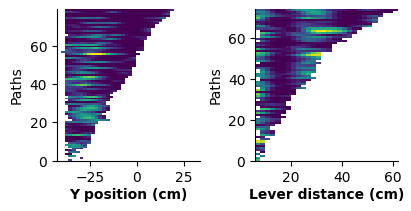

In [19]:
m1 = get_matDic(myHomingDict,cluId=cluId1,pathType = "homingFromLeavingLeverToPeriphery", light = "light", var = "y")
m2 = get_matDic(myHomingDict,cluId=cluId1,pathType = "homingFromLeavingLeverToPeriphery", light = "dark", var = "targetDistance")

nRows=1
nCols=2
axesRowSize,axesColSize = 2,2
fig = plt.figure(figsize=(nCols*axesColSize,nRows*axesRowSize), constrained_layout=True) # figsize = (width,height)
spec = fig.add_gridspec(nrows=nRows,ncols=nCols) # create a GridSpec object to a figure

ax = fig.add_subplot(spec[0])  
oM1 = plotTrialIFRMatrix(ax,m1,sort=True,process=False)

ax = fig.add_subplot(spec[1])
oM2 = plotTrialIFRMatrix(ax,m2,sort=True,process=False)

# Plot functions

In [20]:
def plotAverageLineWithStd(ax, matDict):
    """
    Plot a lineplot with bins on the x-axis and the mean values for each bin aggregated across rows.
    Shows the standard deviation as shaded region.
    """
    if "matrix" not in matDict.keys():
        print("matrix key missing")
        return
    
    m = matDict["matrix"]
    bins = matDict["bins"]
    
    num_columns = m.shape[1]
    
    # Get the current min and max from the original bins
    bins_min = np.min(bins)
    bins_max = np.max(bins)
    
    bin_centers = np.linspace(bins_min, bins_max, num=num_columns)

    # Compute the mean and standard deviation across rows
    mean_vals = np.nanmean(m, axis=0)  # mean for each bin

    # Plot the mean line
    ax.plot(bin_centers, mean_vals, label='Mean')
    
    # Plot the standard deviation as a shaded area
    ax.set_xlabel("Bins")
    ax.set_ylabel("Average value")
    #ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [21]:
def plotAggregateLine(ax, matDict):
    """
    Plot a lineplot with bins on the x-axis, aggregating across rows using seaborn.
    Shows individual examples with alpha=0.2.
    """
    if "matrix" not in matDict.keys():
        print("matrix key missing")
        return
    
    m = matDict["matrix"]
    bins = matDict["bins"]
    
    # Ensure the length of bins matches the number of columns in the matrix
    if len(bins) != m.shape[1]:
        bins = bins[:m.shape[1]]  # Truncate bins if there are more bins than matrix columns
    
    # Convert matrix 'm' into a long-form DataFrame for seaborn
    data = pd.DataFrame(m, columns=bins)
    data = data.melt(var_name='Bins', value_name='Values')  # Long format for seaborn
    
    # Plot individual examples with reduced alpha for transparency
    for row in m:
        ax.plot(bins, row, color='gray', alpha=0.05)

    # Use seaborn to plot the aggregated lines
    sns.lineplot(data=data, x='Bins', y='Values', ax=ax, estimator='mean', ci='sd', label='Aggregated')

    # Set axis labels
    ax.set_xlabel("Bins")
    ax.set_ylabel("Values")
    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [22]:
def plotCombinedHeatmapAndLine(fig, gs, matDict, showXLabel=True, sort=False, showYLabel=True, colorBar=False, aspect="auto",processMatrix=True, noShowY=False):
    """
    Create a combined plot with a 2D heatmap on top and an aggregated line plot below.
    
    Parameters:
    - matDict: Dictionary containing the matrix and related data.
    - showXLabel: Boolean to show x-axis label for heatmap.
    - sort: Boolean to sort the heatmap rows.
    - showYLabel: Boolean to show y-axis label for heatmap.
    - colorBar: Boolean to display the color bar for the heatmap.
    - aspect: Aspect ratio for the heatmap.
    - figsize: Tuple specifying the figure size.
    """
    
    # Create axes for heatmap and line plot
    ax_heatmap = fig.add_subplot(gs[2])
    ax_line = fig.add_subplot(gs[1], sharex=ax_heatmap)
    
    # Plot the line plot
    plotAverageLineWithStd(ax_line, matDict)
    
    ax_line.set_xlabel('')
    
    ax_line.set_ylabel('Firing rate (Hz)', fontsize=GLOBALFONTSIZE)
    
    # Plot the heatmap
    plotTrialIFRMatrix(
        ax_heatmap, 
        matDict, 
        showXLabel=showXLabel, 
        sort=sort, 
        showYLabel=showYLabel, 
        colorBar=colorBar, 
        aspect=aspect,
        process=processMatrix
    )
    
    # Adjust x-axis label position for the heatmap to prevent overlap
    if showXLabel:
        ax_heatmap.set_xlabel(ax_heatmap.get_xlabel())  # Retain if needed
    else:
        ax_heatmap.set_xlabel('')
        
    if noShowY:
        ax_line.set_ylabel('', fontsize=GLOBALFONTSIZE)
        ax_line.set_yticklabels([])
        ax_line.set_yticks([])
        ax_heatmap.set_ylabel('')
        ax_heatmap.set_yticklabels([])
        ax_heatmap.set_yticks([])

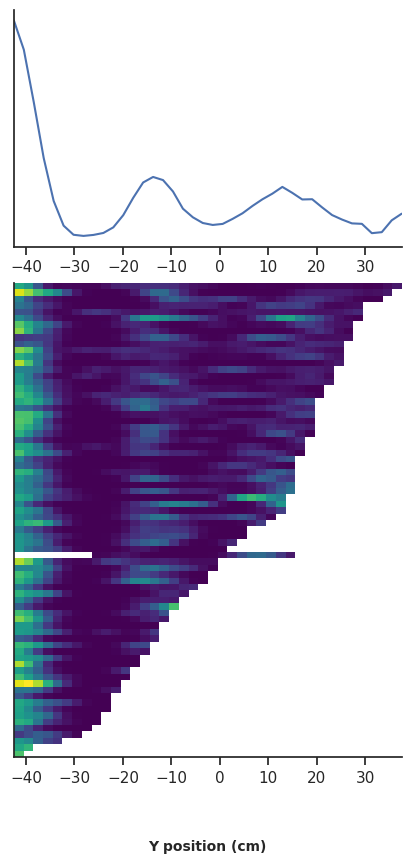

In [23]:
rowSize,colSize= 3,4
ncols=1
nrows=3
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
gs = fig.add_gridspec(ncols=ncols, nrows=nrows,height_ratios = [0.2,1,2])
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
#Data Used For Making the Plot
sns.set_theme(style = 'ticks')

m1 = get_matDic(mySearchDict,cluId=cluId1,pathType = "searchToLeverPath", light = "dark", var = "y")

plotCombinedHeatmapAndLine(fig,gs,m1,sort=True,processMatrix=False,noShowY=True)

In [24]:
m2.keys()

dict_keys(['matrix', 'bins', 'names', 'pathType', 'light', 'var', 'cluId', 'trialNo'])

# Trial matrix correlation

We go back to using trial matrix correlation across trials. This is also similar to Maryam's paper.

Original text in Maryam's github:

We need a way to quantify the reliability of the information in the firing rate of the neuron across trials. We can measure this by calculating the correlation matrix of the trial rate matrix.

Each row of the trial rate matrix has the rate as a function of distance, time, y-coordinate or target distance. We can correlate all pairs of rows to measure how reliable the rate information is across trials.

That can be used to quantify how well information is encoded in the trial matrix, and compare different conditions.

We have a problem with the np.nan in the matrix. We need to consider only values for which both trials have valid values. This means we can't use np.corrcoef().

We are going to use the code quite a lot so we use Numba to compile to C language.

In [25]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [26]:
from numba import jit
import datetime 

@jit()
def rollARow(a):
    """
    Function to roll the firing rate value of a single trial (one row)

    Only rolls the bins from first to last valid entries in the array
    
    The amount of shift is random
    """
    
    if np.sum(~np.isnan(a)) == 0:
        return a
    lastVal = np.where(~np.isnan(a))[0].max()
    firstVal = np.where(~np.isnan(a))[0].min()
    myRange = lastVal-firstVal
    A = a.copy()
    if myRange > 2:
        shift = np.random.randint(low = 0, high=myRange, size=1)[0]
        b = a[firstVal:(lastVal+1)]
        b = np.roll(b,shift)
        A[firstVal:lastVal+1] = b 
    return A


def shuffledTrialMap(m):
    return np.apply_along_axis(rollARow,axis=1,arr=m)


@jit()
def myOwnCorr(x,y,valx,valy):
    """
    Perform pearson correlation on 2 1D arrays, 
    It removes observations with np.nan
    """

    # keep only observations without np.nan
    indices= valx&valy
    #print("valid:",np.sum(indices))
    xx = x[indices]
    yy = y[indices]
    
    if np.sum(indices) <= 2:
        return np.nan
    if np.all(xx==0):
        return np.nan
    if np.all(yy==0):
        return np.nan   
    else :
        return np.corrcoef(xx,yy)[0,1]
    


@jit()
def trialMatrixInternalCorrelation(m):
    """
    Calculate the mean of the correlation matrix (one half) of a matrix m, excluding the diagonal
    """
    # check which values are valid only once and not in the loops
    val = ~np.isnan(m)
    
    dim = m.shape[0]
    res = np.zeros(int(dim*(dim-1)/2)) # number of unique pairs of trials
    count = 0
    for i in range(dim):
        for j in range(i+1,dim):
            res[count] = myOwnCorr(m[i],m[j],val[i],val[j])
            count+=1
    return np.nanmean(res)


def trialMatrixInternalCorrelationShuffle(m,nShuf=10):
    """
    Calculate the mean of the correlation matrix (one half) of matrix m with matrix n, excluding the diagonal
    
    n is generated by shifting the rate values within each trial, keeping sequence but moving it forwards or backwards
    """
    resShuf = np.empty(nShuf) # to store results

    # check which values are valid only once and not in the loops
    valm = ~np.isnan(m)
    dim = m.shape[0]
    res = np.zeros(int(dim*(dim-1)/2)) # for all pairs of trials

    for x in range(nShuf):
        n = shuffledTrialMap(m)
        valn = ~np.isnan(n)
        
        count = 0
        for i in range(dim):
            for j in range(i+1,dim):
                res[count] = myOwnCorr(m[i],n[j],valm[i],valn[j])
                count+=1
        resShuf[x] = np.nanmean(res)
            
    return resShuf

In [27]:
%%time
trialMatrixCorList = []
for path in [ "searchToLeverPath","homingFromLeavingLeverToPeriphery"]: 
    if path == "searchToLeverPath":
        myDict = mySearchDict
    else:
        myDict = myHomingDict
        
    for light in ["light","dark"]:
        for var in ["distance","iTime","targetDistance","y"]:
            cor = [trialMatrixInternalCorrelation(myDict[cluId]["matrix"]["{}_{}_{}".format(path,light,var)]["matrix"]) for cluId in list(myDict.keys())]
            
            df = pd.DataFrame({"cluId": list(mySearchDict.keys()),
                               "path": path,
                               "light":light,
                               "var": var,
                               "cor":cor,})
            
            trialMatrixCorList.append(df)

CPU times: user 36.3 s, sys: 50.1 ms, total: 36.4 s
Wall time: 36.4 s


In [28]:
trialMatrixCor = pd.concat(trialMatrixCorList).reset_index(drop=True)
trialMatrixCor['mouse'] = trialMatrixCor['cluId'].apply(lambda x:x.split('-')[0])
grouped_df = trialMatrixCor.groupby(['mouse','path','light','var'])['cor'].mean().reset_index()

In [29]:
grouped_df

,mouse,path,light,var,cor
0,jp1084,homingFromLeavingLeverToPeriphery,dark,distance,0.110593
1,jp1084,homingFromLeavingLeverToPeriphery,dark,iTime,0.128491
2,jp1084,homingFromLeavingLeverToPeriphery,dark,targetDistance,0.146066
3,jp1084,homingFromLeavingLeverToPeriphery,dark,y,0.027001
4,jp1084,homingFromLeavingLeverToPeriphery,light,distance,0.147099
...,...,...,...,...,...
267,mn8599,searchToLeverPath,dark,y,0.253565
268,mn8599,searchToLeverPath,light,distance,0.265285
269,mn8599,searchToLeverPath,light,iTime,0.284515
270,mn8599,searchToLeverPath,light,targetDistance,0.079262


# Functions for final figure

In [30]:
from scipy.stats import linregress

def plot_map(ax,m):
    ax.imshow(m,cmap='viridis')

    title = "{:.1f} Hz".format(np.nanmax(m))
    ax.text(
        m.shape[0] / 2,
        m.shape[1] + 1,
        title,
        fontsize=GLOBALFONTSIZE,
        horizontalalignment="center",
        verticalalignment="center",
    )
    
    
def load_ifr_behavior(ses,verbose=False):
    """
    Load data files for a session that we need to correlate ifr and navpath variables
    
    ifr_autopi.pkl: the instantaneous firing rate of all neurons as a function of time. 
    navPathSummary.csv: description of navPath that can be analyzed
    navPathInstan.csv: contains variables that changes within a single navPath (e.g., distance run and speed)
    
    """
    fn = ses.path+"/ifr_autopi.pkl"
    if verbose:
        print("loading",fn)
    with open(fn, 'rb') as intp:
        ifr = pickle.load(intp)
    
    fn = ses.path+"/navPathSummary.csv"
    if verbose:
        print("loading",fn)
    navPathSummary = pd.read_csv(fn)
    
    fn = ses.path+"/navPathInstan.csv"
    if verbose:
        print("loading",fn)
    navPathInstan = pd.read_csv(fn)
    
    
    # all the timeRes values in our navPathInstan should be in IFR time array
    intol = isin_tolerance(navPathInstan.timeRes,ifr[1],tol=0.00001) # function from setup_project.py
    if np.sum(intol) != navPathInstan.shape[0]:
        raise ValueError("Not all values of the navPathInstan are in the ifr time")
    
    return ifr, navPathSummary, navPathInstan

def load_spikeA_one_session(ses,pose_file_extension = ".pose.npy"):

    ses.load_parameters_from_files() 
    ap = Animal_pose(ses)
    ap.pose_file_extension = pose_file_extension # This means that the ap will always load from this extension
    ap.load_pose_from_file()
    stl = Spike_train_loader()
    stl.load_spike_train_kilosort(ses)
    cg = Cell_group(stl,ap)
    # we want to keep ap and cg after the function ends, one way is to store it in our sSes
    ses.ap = ap
    ses.cg = cg
    
def plot_spike_on_path_y_sorted_by_lever_y_position(ax, cluId,condition, offset = 40,legend=True,regression_line=False,yLabel='',c='red'):
    cluNo = cluId.split("_")[1]
    session = cluId.split("_")[0]
   
    sSes = [sSes for sSes in sSessions if sSes.name == session][0]
    ses = myProject.getSession(session)

    load_spikeA_one_session(sSes)


    fn=ses.path+"/ses.pickle"
    with open(fn, 'rb') as handle:
        ses=pickle.load(handle)

    getSearchHomingIntervals(ses,sSes)
        
    
    ifr, navs, inav = load_ifr_behavior(ses)

    
    
    sSes.ap.set_intervals(ses.intervalDict[condition])
    
    pathType = condition.split("_")[0]
    light = condition.split("_")[1]
    
    trialNos = navs[(navs.type==pathType) & (navs.nLeverPresses >= 1) & (navs.light==light)].trialNo
    leverYs = [ ses.trialList[tn-1].lever.leverCenter[1]  for tn in trialNos] 
    
    lev = np.array(leverYs)
    

    sSes.ap.set_intervals(ses.intervalDict[condition])
    for i, rk in enumerate(lev.argsort()):
        inter = ses.intervalDict[condition][rk]
        indices = np.logical_and(sSes.ap.pose[:,0]>=inter[0], sSes.ap.pose[:,0]<=inter[1])
        sSes.ap.pose[indices,1] = sSes.ap.pose[indices,1] + offset*i
    
    n = [n for n in sSes.cg.neuron_list if n.name==cluNo][0]
    n.spike_train.set_intervals(ses.intervalDict[condition])
    spike_posi = n.spatial_properties.spike_position()        
    

    ax.scatter(sSes.ap.pose[:,1],sSes.ap.pose[:,2],s=2, color="lightgray",label="Path")
    ax.scatter(spike_posi[:,0],spike_posi[:,1],s=5,color=c,alpha=0.75,label="Spikes")
    


    # regression line
    if regression_line:
        indices = ~np.any(np.isnan(spike_posi),axis=1)
        slope, intercept, _,_,_ = linregress(spike_posi[indices])
        x = np.linspace(np.nanmin(spike_posi[:,0]),np.nanmax(spike_posi[:,0]),2)
        ax.plot(x,x*slope+intercept)

    
    argSort = lev.argsort()
    x = [i*offset for i in range(argSort.shape[0])]
    ax.scatter(x, lev[argSort],color="black",s=5,label="Lever")
    
    
    ax.set_ylabel(yLabel,fontsize=GLOBALFONTSIZE,labelpad=-5)
    ax.set_xticks([])
    ax.set_xlabel("Trials",fontsize=GLOBALFONTSIZE)
    ax.set_ylim(-45,40)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    
    if legend:
        ax.legend()
        
        sns.move_legend(ax, 'lower center',
                    bbox_to_anchor = (0.5,0.5),
                    ncol=1,
                    title=None,
                    frameon=False,
                    fontsize = GLOBALFONTSIZE)
        


def plot_cell_row(gs, rowNum, cell_id, ld='dark',legend=True):
    
    # Define conditions based on the 'ld' parameter
    condition1 = f"searchToLeverPath_{ld}"
    condition2 = f"atLever_{ld}"
    condition4 = f"homingFromLeavingLeverToPeriphery_{ld}"
    

    # Retrieve the index for the specified cell_id
    try:
        ind = cells[cells.cluId == cell_id].index[0]
    except IndexError:
        raise ValueError(f"cell_id '{cell_id}' not found in the 'cells' DataFrame.")

    # Extract the relevant map
    m = myMaps["circ80_1"][ind, :-1, :-1]

    # Create a subgridspec for 1 row and 4 columns within the specified grid area

    # Create individual axes for each subplot
    ax0 = fig.add_subplot(gs[rowNum,0])
    ax1 = fig.add_subplot(gs[rowNum,1])
    ax2 = fig.add_subplot(gs[rowNum,2])
    ax3 = fig.add_subplot(gs[rowNum,3])
    ax = [ax0, ax1, ax2, ax3]

    # Plot the first map (RF1)
    plot_map(ax[0], m)
    ax[0].axis('off')
    ax[0].set_title('RF1', fontsize=GLOBALFONTSIZE)

    # Plot spike positions for 'Search' condition
    plot_spike_on_path_y_sorted_by_lever_y_position(ax[1], cell_id, condition1, yLabel='Y Position',legend=legend)
    ax[1].set_title('Search', fontsize=GLOBALFONTSIZE)

    # Plot spike positions for 'At Lever' condition
    plot_spike_on_path_y_sorted_by_lever_y_position(ax[2], cell_id, condition2, legend=False)
    ax[2].set_title('At Lever', fontsize=GLOBALFONTSIZE)

    # Create partial functions for lever and room references
    leverRef_partial = partial(
        plotLeverMap,
        cluId=cell_id,
        maps=myLeverMaps,
        condition=f'all_{ld}',
        title='Lever-ref.',
        r='none'
    )

    roomRef_partial = partial(
        plotLeverMap,
        cluId=cell_id,
        maps=myLeverMaps,
        condition=f'all_{ld}',
        title='Room-ref.',
        r='arenaref'
    )

    # Add inset plots to the 'At Lever' subplot
    add_inset_plot(ax[2], leverRef_partial,
                   inset_width="30%", inset_height="30%",
                   loc='lower right', borderpad=0)

    add_inset_plot(ax[2], roomRef_partial,
                   inset_width="30%", inset_height="30%",
                   loc='upper left', borderpad=0.8)

    # Plot spike positions for 'Homing' condition
    plot_spike_on_path_y_sorted_by_lever_y_position(ax[3], cell_id, condition4, legend=False)
    ax[3].set_title('Homing', fontsize=GLOBALFONTSIZE)

    # Optionally, return the axes if further customization is needed
    return ax

In [31]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from functools import partial

def add_inset_plot(parent_ax, plot_func, inset_width="50%", inset_height="50%", loc='lower right', borderpad=2, **kwargs):
    """
    Adds an inset plot to a given Matplotlib axis.

    Parameters:
    - parent_ax (matplotlib.axes.Axes): The parent axis to which the inset will be added.
    - plot_func (callable): A function that takes a Matplotlib axis as its first argument and plots on it.
    - inset_width (str or float, optional): Width of the inset axes. Can be a percentage string like "50%" or a fixed size like "3cm". Default is "50%".
    - inset_height (str or float, optional): Height of the inset axes. Can be a percentage string like "50%" or a fixed size like "3cm". Default is "50%".
    - loc (str or int, optional): Location code for the inset. Accepts same values as Matplotlib's `loc` parameter (e.g., 'upper right', 1). Default is 'lower right'.
    - borderpad (int, optional): Padding between the parent and inset axes, measured in font-size multiples. Default is 2.
    - **kwargs: Additional keyword arguments passed to `inset_axes`.

    Returns:
    - inset_ax (matplotlib.axes.Axes): The newly created inset axes.
    """
    # Create inset axes within the parent axis
    inset_ax = inset_axes(parent_ax,
                          width=inset_width,
                          height=inset_height,
                          loc=loc,
                          borderpad=borderpad,
                          **kwargs)
    
    # Call the provided plotting function with the inset axes
    plot_func(inset_ax)
    
    return inset_ax

In [32]:
def plotLeverMap(axes, cluId, maps,condition='all_light',r='none',title='',showYLabel=True):

    nCells=maps["map"]["all_light"]["none"]['data'].shape[0]
    
    for i in range(nCells):
        if maps["map"][condition][r]['cluid'][i] == cluId:
            mapToPlot = maps["map"][condition][r]['data'][i]
            break
        
    
    im = mapToPlot
    im=im[:,~np.isnan(im).all(axis=0)]
    im=im[~np.isnan(im).all(axis=1),:]
    axes.imshow(im.T,origin="lower",cmap='viridis',interpolation=None)
    #axes.set_title(f'{np.round(np.nanmax(im),2)} Hz')
    axes.set_title(title,fontsize=GLOBALFONTSIZE-2,pad=-5)
    #axes.axis('off')

    axes.set_xlabel('')
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    axes.set_xticks([])
    axes.set_yticks([])
    

In [33]:
argSort = get_lever_y_sort_order(cluId=cluId2,condition='homingFromLeavingLever_dark')

# Final figure

In [34]:
def add_text(ax, x, y, label, fw="normal"):
    ax.text(
        x,
        y,
        label,
        style="normal",
        fontweight=fw,
        fontsize=GLOBALFONTSIZE + 4,
        verticalalignment="center",
        horizontalalignment="center",
        transform=ax.transAxes,
    )

# Statistic figures

In [35]:
%%time

# Get a stat on these cells
trialMatrixCorList = []
for path in [ "searchToLeverPath","homingFromLeavingLeverToPeriphery"]: #,"homingFromLeavingLeverToPeriphery"
    if path == "searchToLeverPath":
        myDict = mySearchDict
    else:
        myDict = myHomingDict
        
    for light in ["light","dark"]:
        for var in ["distance","iTime","targetDistance","y"]:
            cor = [trialMatrixInternalCorrelation(myDict[cluId]["matrix"]["{}_{}_{}".format(path,light,var)]["matrix"]) for cluId in list(myDict.keys())]
            
            df = pd.DataFrame({"cluId": list(mySearchDict.keys()),
                               "path": path,
                               "light":light,
                               "var": var,
                               "cor":cor,})
            
            trialMatrixCorList.append(df)


CPU times: user 28.6 s, sys: 0 ns, total: 28.6 s
Wall time: 28.6 s


In [36]:
len(trialMatrixCor.cluId.unique())

931

In [37]:
mySearchDict.keys()

dict_keys(['mn8578-05122021-0108_61', 'mn8578-05122021-0108_161', 'mn8578-05122021-0108_197', 'mn8578-05122021-0108_233', 'mn8578-05122021-0108_238', 'mn8578-05122021-0108_247', 'mn8578-05122021-0108_303', 'mn8578-06122021-0107_43', 'mn8578-06122021-0107_182', 'mn8578-06122021-0107_184', 'mn8578-06122021-0107_206', 'mn8578-06122021-0107_212', 'mn8578-06122021-0107_257', 'mn8578-07122021-0107_35', 'mn8578-07122021-0107_47', 'mn8578-08122021-0110_33', 'mn8578-08122021-0110_178', 'mn8578-08122021-0110_180', 'mn8578-08122021-0110_241', 'mn8578-08122021-0110_360', 'mn8578-10122021-0107_138', 'mn8578-10122021-0107_140', 'mn8578-10122021-0107_156', 'mn8578-10122021-0107_162', 'mn8578-10122021-0107_217', 'mn8578-10122021-0107_229', 'mn8578-10122021-0107_239', 'mn8578-10122021-0107_249', 'mn8578-15122021-0107_11', 'mn8578-15122021-0107_12', 'mn8578-15122021-0107_25', 'mn8578-15122021-0107_117', 'mn8578-15122021-0107_183', 'mn8578-15122021-0107_191', 'mn8578-15122021-0107_235', 'mn8578-15122021-

In [38]:
# I use the same method as Maryam's paper
# I get a discriptive stats dataframe first

myList = []
for myDict,path in zip([mySearchDict,myHomingDict],["searchToLeverPath","homingFromLeavingLeverToPeriphery"]):
    for var in ["y","distance","iTime","targetDistance"]:
        for light in ["light","dark"]:
            df = pd.concat([ trialMatrixDescriptiveStats(get_matDic(myDict,cluId=cluId,pathType = path, light =light, var = var)) for cluId in mySearchDict.keys()])
            myList.append(df)
tmStats = pd.concat(myList)

In [39]:
trialMatrixCor = pd.concat(trialMatrixCorList).reset_index(drop=True)
trialMatrixCor['mouse'] = trialMatrixCor['cluId'].apply(lambda x:x.split('-')[0])
grouped_df = trialMatrixCor.groupby(['mouse','path','light','var'])['cor'].mean().reset_index()

In [40]:
tmc = trialMatrixCor
tmc.rename(columns = {'path':'pathType', 'var':'behavioralVariable'}, inplace = True)
tmStats = pd.merge(tmStats,tmc,on=["cluId","pathType","light","behavioralVariable"])

In [41]:
from statannotations.Annotator import Annotator

def plot_behavioral_variable_box_plot(ax,inputDf,varCond='targetDistance',title='Lever distance',legend=True,yl=0.4):
    od = ['searchToLeverPath','homingFromLeavingLeverToPeriphery']
    inputDf = inputDf.copy().replace({'dark':'Dark','light':'Light'})
    hue_order = ['Dark','Light']
    colPal = {"Light": "#FC8D03", "Dark": "#5950E9"}
    
    b = sns.boxplot(data=inputDf[inputDf['var'] == varCond],x='path',y='cor',palette=colPal,hue_order=hue_order,hue='light',order =od,showfliers=False,ax=ax,**boxplot_kwargs)
    sns.stripplot(data=inputDf[inputDf['var'] == varCond],x='path',y='cor',palette=colPal,hue_order=hue_order,hue='light',order =od,dodge=True,legend=False,ax=ax,**stripplot_kwargs)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    ax.set_ylim(0,yl)
    ax.set_xlabel('')
    ax.set_ylabel('Trial matrix corr.',fontsize=GLOBALFONTSIZE)
    ax.set_title(title,fontsize=GLOBALFONTSIZE)
    
    
    if legend:
        sns.move_legend(
            b,
            "lower center",
            bbox_to_anchor=(0.15, 0.8),
            ncol=1,
            title=None,
            frameon=False,
            fontsize=GLOBALFONTSIZE,
        )
    else:
        ax.legend([],[],frameon=False)
        
    pairs = [[('searchToLeverPath','Dark'),('homingFromLeavingLeverToPeriphery','Dark')],[('searchToLeverPath','Light'),('homingFromLeavingLeverToPeriphery','Light')]]

    annotator = Annotator(b, pairs, data=inputDf[inputDf['var'] == varCond],hue='light',x='path',y='cor',order =od,hue_order=hue_order)
    annotator.configure(test='Wilcoxon', text_format='star', loc='inside',comparisons_correction='holm') 
    annotator.apply_and_annotate()
    
    ax.set_xticklabels(['Search','Homing'],fontsize=GLOBALFONTSIZE)
    
    number = len(inputDf[inputDf['var'] == varCond].mouse.unique())
    ax.text(0.85,0.95, f'N = {number}',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)
    
    

In [42]:
def plot_distance_lever_box_plot(ax,inputDf,pathCond='searchToLeverPath',title='Search',legend=True,yl=0.4):
    od = ['distance','y','targetDistance','iTime']
    inputDf = inputDf.copy().replace({'dark':'Dark','light':'Light'})
    labelList = ['Distance','Y-\nposition','Lever\ndistance','Time']
    hue_order = ['Dark','Light']
    colPal = {"Light": "#FC8D03", "Dark": "#5950E9"}
   
    
    b = sns.boxplot(data=inputDf[inputDf['path'] == pathCond],x='var',y='cor',hue='light',palette=colPal,order =od,hue_order=hue_order,showfliers=False,ax=ax,**boxplot_kwargs)
    sns.stripplot(data=inputDf[inputDf['path'] == pathCond],x='var',y='cor',hue='light',palette=colPal,order =od,hue_order=hue_order,dodge=True,legend=False,ax=ax,**stripplot_kwargs)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    ax.set_ylim(0,yl)
    ax.set_xlabel('')
    ax.set_ylabel('Trial matrix corr.',fontsize=GLOBALFONTSIZE)
    ax.set_title(title,fontsize=GLOBALFONTSIZE)
    ax.set_xticklabels(labelList,fontsize=GLOBALFONTSIZE-1)
    
    
    if legend:
        sns.move_legend(
            b,
            "lower center",
            bbox_to_anchor=(0.15, 0.8),
            ncol=1,
            title=None,
            frameon=False,
            fontsize=GLOBALFONTSIZE,
        )
    else:
        ax.legend([],[],frameon=False)
        
    
    if pathCond == 'searchToLeverPath':
        pairs = [[('distance','Dark'),('y','Dark')],
                [('iTime','Dark'),('y','Dark')]]
        
    elif pathCond == 'homingFromLeavingLeverToPeriphery':
            pairs = [[('targetDistance','Dark'),('y','Dark')],
                [('targetDistance','Dark'),('distance','Dark')]]

    annotator = Annotator(b, pairs, data=inputDf[inputDf['path'] == pathCond],x='var',y='cor',hue='light',hue_order=hue_order,order =od)
    annotator.configure(test='Wilcoxon', text_format='star', loc='inside',comparisons_correction='holm') 
    annotator.apply_and_annotate()
    
    number = len(inputDf[inputDf['path'] == pathCond].mouse.unique())
    ax.text(0.85,0.95, f'N = {number}',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)
    


# Final figure

In [43]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def plot_spike_on_path_legend(ax, location=(0.86, 0.98)):
    # Create custom legend elements
    gray_dot = mlines.Line2D([], [], color='gray', marker='o', linestyle='None', markersize=5, label='Path')
    red_dot = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=5, label='Spikes')
    black_dot = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=5, label='Lever')

    # Add the legend to the axis
    ax.legend(handles=[gray_dot, red_dot, black_dot], loc='upper center',ncol=1, 
              bbox_to_anchor=location, frameon=False,handletextpad=0.1,  # Reduces space between the marker and the text
        columnspacing=0.1,fontsize=GLOBALFONTSIZE-2)


In [44]:
def plot_behavioral_variable_box_plot_shuffle(ax,inputDf,varCond='targetDistance',title='Lever distance',legend=True,yl=0.4):
    od = ['searchToLeverPath','homingFromLeavingLeverToPeriphery']
    inputDf = inputDf.copy().replace({'dark':'Dark','light':'Light'})
    hue_order = ['Dark','Light','Shuffle']
    colPal = {"Light": "#FC8D03", "Dark": "#5950E9","Shuffle":'#e5e5e5'}
    
    b = sns.boxplot(data=inputDf[inputDf['var'] == varCond],x='path',y='cor',palette=colPal,hue_order=hue_order,hue='light',order =od,showfliers=False,ax=ax,**boxplot_kwargs)
    sns.stripplot(data=inputDf[inputDf['var'] == varCond],x='path',y='cor',palette=colPal,hue_order=hue_order,hue='light',order =od,dodge=True,legend=False,ax=ax,**stripplot_kwargs)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    ax.set_ylim(0,yl)
    ax.set_xlabel('')
    ax.set_ylabel('Trial matrix corr.',fontsize=GLOBALFONTSIZE)
    ax.set_title(title,fontsize=GLOBALFONTSIZE)
    
    
    if legend:
        sns.move_legend(
            b,
            "lower center",
            bbox_to_anchor=(0.15, 0.8),
            ncol=1,
            title=None,
            frameon=False,
            fontsize=GLOBALFONTSIZE,
        )
    else:
        ax.legend([],[],frameon=False)
    if varCond == 'y':
        pairs = [[('searchToLeverPath','Dark'),('homingFromLeavingLeverToPeriphery','Dark')],
                 [('searchToLeverPath','Dark'),('searchToLeverPath','Shuffle')]]
    elif varCond == 'targetDistance':
        pairs = [[('searchToLeverPath','Dark'),('homingFromLeavingLeverToPeriphery','Dark')],
                 [('homingFromLeavingLeverToPeriphery','Dark'),('homingFromLeavingLeverToPeriphery','Shuffle')]]

    annotator = Annotator(b, pairs, data=inputDf[inputDf['var'] == varCond],hue='light',x='path',y='cor',order =od,hue_order=hue_order)
    annotator.configure(test='Wilcoxon', text_format='star', loc='inside') 
    annotator.apply_and_annotate()
    
    ax.set_xticklabels(['Search','Homing'],fontsize=GLOBALFONTSIZE)
    
    number = len(inputDf[inputDf['var'] == varCond].mouse.unique())
    ax.text(0.85,0.95, f'N = {number}',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)
        

In [45]:
sliceDf = grouped_df[grouped_df.light == 'dark']

# Extract the two groups
group_y = sliceDf[(sliceDf.path == 'searchToLeverPath') & (sliceDf['var'] == 'y')].cor.values
group_distance = sliceDf[(sliceDf.path == 'searchToLeverPath') & (sliceDf['var'] == 'distance')].cor.values

# Calculate medians
median_y = np.median(group_y)
median_distance = np.median(group_distance)

# Print the medians
print(f"Median of 'y': {median_y}")
print(f"Median of 'distance': {median_distance}")

# Compare medians
if median_y > median_distance:
    print("'y' has larger values on average.")
elif median_y < median_distance:
    print("'distance' has larger values on average.")
else:
    print("'y' and 'distance' have similar median values.")

Median of 'y': 0.26323139045315924
Median of 'distance': 0.2603062686076829
'y' has larger values on average.


# Final new figure split between light and dark with stats also split

In [46]:
barplot_kwargs = dict(
    {
        "linewidth": 1.5,
        "alpha": 1,
        "edgecolor": "black",
        "capsize": 0.4,
        "errwidth": 1.5,
        "facecolor": "#FFFFFF",
        "width": 0.6,
    }
)

In [47]:
def plot_behavioral_variable_box_plot_only_light(ax,inputDf,varCond='targetDistance',title='Lever distance',legend=False,yl=0.4,lightCond='dark'):
    od = ['searchToLeverPath','homingFromLeavingLeverToPeriphery']
    inputDf = inputDf[inputDf.light == lightCond].copy()
    
    inputDf = inputDf.copy().replace({'dark':'Dark','light':'Light'}) 
    
    hue_order = ['Dark','Light']
    colPal = {"light": "#FC8D03", "dark": "#5950E9"}
    bar_color = colPal[lightCond]
    
    b = sns.barplot(data=inputDf[inputDf['var'] == varCond],x='path',y='cor',color=bar_color,order =od,ax=ax,**barplot_kwargs)
    sns.stripplot(data=inputDf[inputDf['var'] == varCond],x='path',y='cor',color=bar_color,order =od,dodge=True,legend=False,ax=ax,**stripplot_kwargs)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    ax.set_ylim(0,yl)
    ax.set_xlabel('')
    ax.set_ylabel('Trial matrix corr.',fontsize=GLOBALFONTSIZE)
    ax.set_title(title,fontsize=GLOBALFONTSIZE)
    
    
    if legend:
        sns.move_legend(
            b,
            "lower center",
            bbox_to_anchor=(0.15, 0.8),
            ncol=1,
            title=None,
            frameon=False,
            fontsize=GLOBALFONTSIZE,
        )
    else:
        ax.legend([],[],frameon=False)
        
    pairs = [[('searchToLeverPath'),('homingFromLeavingLeverToPeriphery')]]

    annotator = Annotator(b, pairs, data=inputDf[inputDf['var'] == varCond],x='path',y='cor',order =od)
    annotator.configure(test='Wilcoxon', text_format='star', loc='inside',comparisons_correction='holm') 
    annotator.apply_and_annotate()
    
    ax.set_xticklabels(['Search','Homing'],fontsize=GLOBALFONTSIZE)
    
    number = len(inputDf[inputDf['var'] == varCond].mouse.unique())
    ax.text(0.85,0.95, f'N = {number}',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)

In [48]:
def plot_distance_lever_box_plot_only_light(ax,inputDf,pathCond='searchToLeverPath',title='Search',legend=False,yl=0.4,lightCond='dark'):
    od = ['distance','y','targetDistance','iTime']
    inputDf = inputDf[inputDf.light == lightCond].copy()
    inputDf = inputDf.copy().replace({'dark':'Dark','light':'Light'})
    labelList = ['Distance','Y-\npos.','Lever\ndistance','Time']
    hue_order = ['Dark','Light']
    colPal = {"light": "#FC8D03", "dark": "#5950E9"}
    bar_color = colPal[lightCond]
   
    
    b = sns.barplot(data=inputDf[inputDf['path'] == pathCond],x='var',y='cor',color=bar_color,order =od,ax=ax,**barplot_kwargs)
    sns.stripplot(data=inputDf[inputDf['path'] == pathCond],x='var',y='cor',color=bar_color,order =od,legend=False,ax=ax,**stripplot_kwargs)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    ax.set_ylim(0,yl)
    ax.set_xlabel('')
    ax.set_ylabel('Trial matrix corr.',fontsize=GLOBALFONTSIZE)
    ax.set_title(title,fontsize=GLOBALFONTSIZE)
    ax.set_xticklabels(labelList,fontsize=GLOBALFONTSIZE-1)
    
    
    if legend:
        sns.move_legend(
            b,
            "lower center",
            bbox_to_anchor=(0.15, 0.8),
            ncol=1,
            title=None,
            frameon=False,
            fontsize=GLOBALFONTSIZE,
        )
    else:
        ax.legend([],[],frameon=False)
    
    if lightCond == 'dark':
    
        if pathCond == 'searchToLeverPath':
            pairs = [[('distance'),('y')],
                    [('iTime'),('y')]]
            
        elif pathCond == 'homingFromLeavingLeverToPeriphery':
                pairs = [[('targetDistance'),('y')],
                    [('targetDistance'),('distance')]]
                
    elif lightCond == 'light':
        if pathCond == 'searchToLeverPath':
            pairs = [[('distance'),('targetDistance')],
                    [('targetDistance'),('y')]]
            
        elif pathCond == 'homingFromLeavingLeverToPeriphery':
                pairs = [[('targetDistance'),('y')],
                    [('targetDistance'),('distance')]]

    annotator = Annotator(b, pairs, data=inputDf[inputDf['path'] == pathCond],x='var',y='cor',order =od)
    annotator.configure(test='Wilcoxon', text_format='star', loc='inside',comparisons_correction='holm') 
    annotator.apply_and_annotate()
    
    number = len(inputDf[inputDf['path'] == pathCond].mouse.unique())
    ax.text(0.85,0.95, f'N = {number}',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)

# Figure between light and dark

In [49]:
def plot_cell_row_no_lever(gs, rowNum, cell_id, ld='dark',legend=True):
    
    # Define conditions based on the 'ld' parameter
    condition1 = f"searchToLeverPath_{ld}"
    condition4 = f"homingFromLeavingLeverToPeriphery_{ld}"

    # Retrieve the index for the specified cell_id
    try:
        ind = cells[cells.cluId == cell_id].index[0]
    except IndexError:
        raise ValueError(f"cell_id '{cell_id}' not found in the 'cells' DataFrame.")

    # Extract the relevant map
    m = myMaps["circ80_1"][ind, :-1, :-1]

    # Create a subgridspec for 1 row and 4 columns within the specified grid area

    # Create individual axes for each subplot
    ax0 = fig.add_subplot(gs[rowNum,0])
    ax1 = fig.add_subplot(gs[rowNum,1])
    ax2 = fig.add_subplot(gs[rowNum,2])
    ax = [ax0, ax1, ax2]

    # Plot the first map (RF1)
    plot_map(ax[0], m)
    ax[0].axis('off')
    ax[0].set_title('RF1', fontsize=GLOBALFONTSIZE)

    # Plot spike positions for 'Search' condition
    plot_spike_on_path_y_sorted_by_lever_y_position(ax[1], cell_id, condition1, yLabel='Y Position',legend=legend)
    ax[1].set_title('Search', fontsize=GLOBALFONTSIZE)


    # Plot spike positions for 'Homing' condition
    plot_spike_on_path_y_sorted_by_lever_y_position(ax[2], cell_id, condition4, legend=False)
    ax[2].set_title('Homing', fontsize=GLOBALFONTSIZE)

    return ax

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

searchToLeverPath vs. homingFromLeavingLeverToPeriphery: Wilcoxon test (paired samples) with Holm-Bonferroni correction, P_val:1.526e-05 Stat=0.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

searchToLeverPath vs. homingFromLeavingLeverToPeriphery: Wilcoxon test (paired samples) with Holm-Bonferroni correction, P_val:7.629e-05 Stat=3.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

distance vs. y: Wilcoxon test (paired samples) with Holm-Bonferroni correction, P_val:1.068e-03 Stat=1.200e+01
y vs. iTi

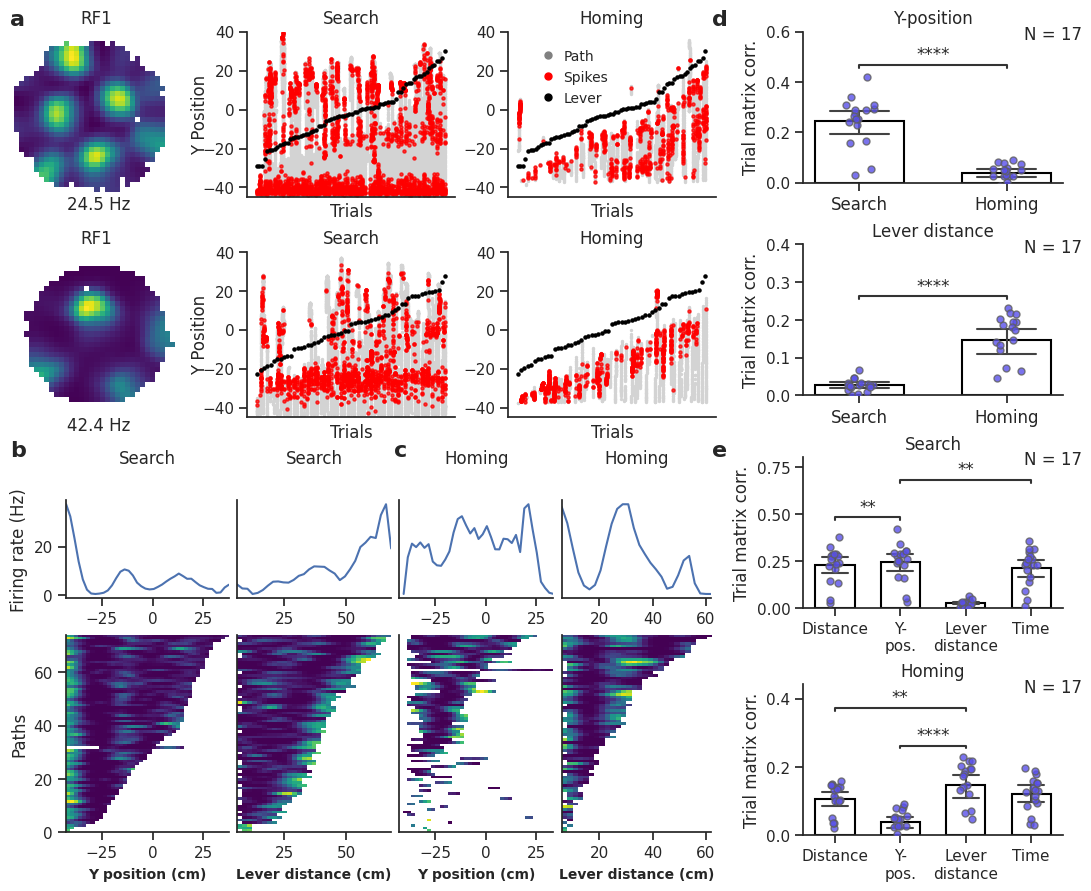

In [50]:
from matplotlib.gridspec import GridSpecFromSubplotSpec
rowSize,colSize= 2.2,1.8
ncols=6
nrows=4
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
gs = fig.add_gridspec(ncols=ncols, nrows=nrows,width_ratios=[1,1,1,1,0.05,2])
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

sns.set_theme(style = 'ticks')

# NOTE Examples first
gsExamples = GridSpecFromSubplotSpec(2,3,subplot_spec=gs[:2,:4],height_ratios=[1,1],width_ratios=[1,1.2,1.2])

cluId1 = 'jp3269-28112022-0108_52'
plot_cell_row_no_lever(gsExamples,0,cluId1,legend=False)

cluId2 = 'jp486-24032023-0108_490'
plot_cell_row_no_lever(gsExamples,1,cluId2,legend=False)



# PLot for a first example
gsBottomExamples = GridSpecFromSubplotSpec(1,4,subplot_spec=gs[2:,:4],width_ratios=[1.4,1,1,1])

# Search Y Position
gs_1 = GridSpecFromSubplotSpec(3,1,subplot_spec=gsBottomExamples[0],height_ratios=[0.2,1,2])
m1 = get_matDic(mySearchDict,cluId=cluId1,pathType = "searchToLeverPath", light = "dark", var = "y")
plotCombinedHeatmapAndLine(fig,gs_1,m1,sort=True,processMatrix=False)

ax0 = fig.add_subplot(gs_1[0,:])
ax0.set_title('Search',fontsize=GLOBALFONTSIZE)
ax0.axis('off')

# Search Lever Position
gs_1 = GridSpecFromSubplotSpec(3,1,subplot_spec=gsBottomExamples[1],height_ratios=[0.2,1,2])
m1 = get_matDic(mySearchDict,cluId=cluId1,pathType = "searchToLeverPath", light = "dark", var = "targetDistance")
plotCombinedHeatmapAndLine(fig,gs_1,m1,sort=True,processMatrix=False,noShowY=True)

ax0 = fig.add_subplot(gs_1[0,:])
ax0.set_title('Search',fontsize=GLOBALFONTSIZE)
ax0.axis('off')

#Homing Y Position
gs_1 = GridSpecFromSubplotSpec(3,1,subplot_spec=gsBottomExamples[2],height_ratios=[0.2,1,2])
m1 = get_matDic(myHomingDict,cluId=cluId1,pathType = "homingFromLeavingLeverToPeriphery", light = "dark", var = "y")
plotCombinedHeatmapAndLine(fig,gs_1,m1,sort=True,processMatrix=False,noShowY=True)

ax0 = fig.add_subplot(gs_1[0,:])
ax0.set_title('Homing',fontsize=GLOBALFONTSIZE)
ax0.axis('off')

#Homing Lever Position
gs_1 = GridSpecFromSubplotSpec(3,1,subplot_spec=gsBottomExamples[3],height_ratios=[0.2,1,2])
m1 = get_matDic(myHomingDict,cluId=cluId1,pathType = "homingFromLeavingLeverToPeriphery", light = "dark", var = "targetDistance")
plotCombinedHeatmapAndLine(fig,gs_1,m1,sort=True,processMatrix=False,noShowY=True)

ax0 = fig.add_subplot(gs_1[0,:])
ax0.set_title('Homing',fontsize=GLOBALFONTSIZE)
ax0.axis('off')


# NOTE Add stats
gsStats = GridSpecFromSubplotSpec(4,1,subplot_spec=gs[:,5])

ax0=fig.add_subplot(gsStats[0])
plot_behavioral_variable_box_plot_only_light(ax0,grouped_df,varCond='y',title='Y-position',yl=0.6,lightCond='dark')

ax0=fig.add_subplot(gsStats[1])
plot_behavioral_variable_box_plot_only_light(ax0,grouped_df,varCond='targetDistance',title='Lever distance',legend=False,lightCond='dark')

ax0=fig.add_subplot(gsStats[2])
plot_distance_lever_box_plot_only_light(ax0,grouped_df,pathCond='searchToLeverPath',title='Search',yl=0.8)

ax0=fig.add_subplot(gsStats[3])
plot_distance_lever_box_plot_only_light(ax0,grouped_df,pathCond='homingFromLeavingLeverToPeriphery',title='Homing',yl=0.4,legend=False)


# NOTE Add figure legends
gsLegend = GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[:,:])
# #***********************************#
ax0 = fig.add_subplot(gsLegend[:,:])
plot_spike_on_path_legend(ax0, location=(0.52, 0.98))
#Add figure legend
add_text(ax0,0,1,'a',fw='900')
add_text(ax0,0,0.5,'b',fw='900')
add_text(ax0,0.36,0.5,'c',fw='900')

add_text(ax0,0.66,1,'d',fw='900')
add_text(ax0,0.66,0.5,'e',fw='900')
ax0.axis('off')
###

plt.savefig('../../Output/Figure3.pdf', bbox_inches='tight', dpi=300)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

searchToLeverPath vs. homingFromLeavingLeverToPeriphery: Wilcoxon test (paired samples) with Holm-Bonferroni correction, P_val:1.526e-04 Stat=5.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

searchToLeverPath vs. homingFromLeavingLeverToPeriphery: Wilcoxon test (paired samples) with Holm-Bonferroni correction, P_val:2.090e-03 Stat=1.500e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

y vs. targetDistance: Wilcoxon test (paired samples) with Holm-Bonferroni correction, P_val:1.526e-05 Stat=0.000e+00
dis

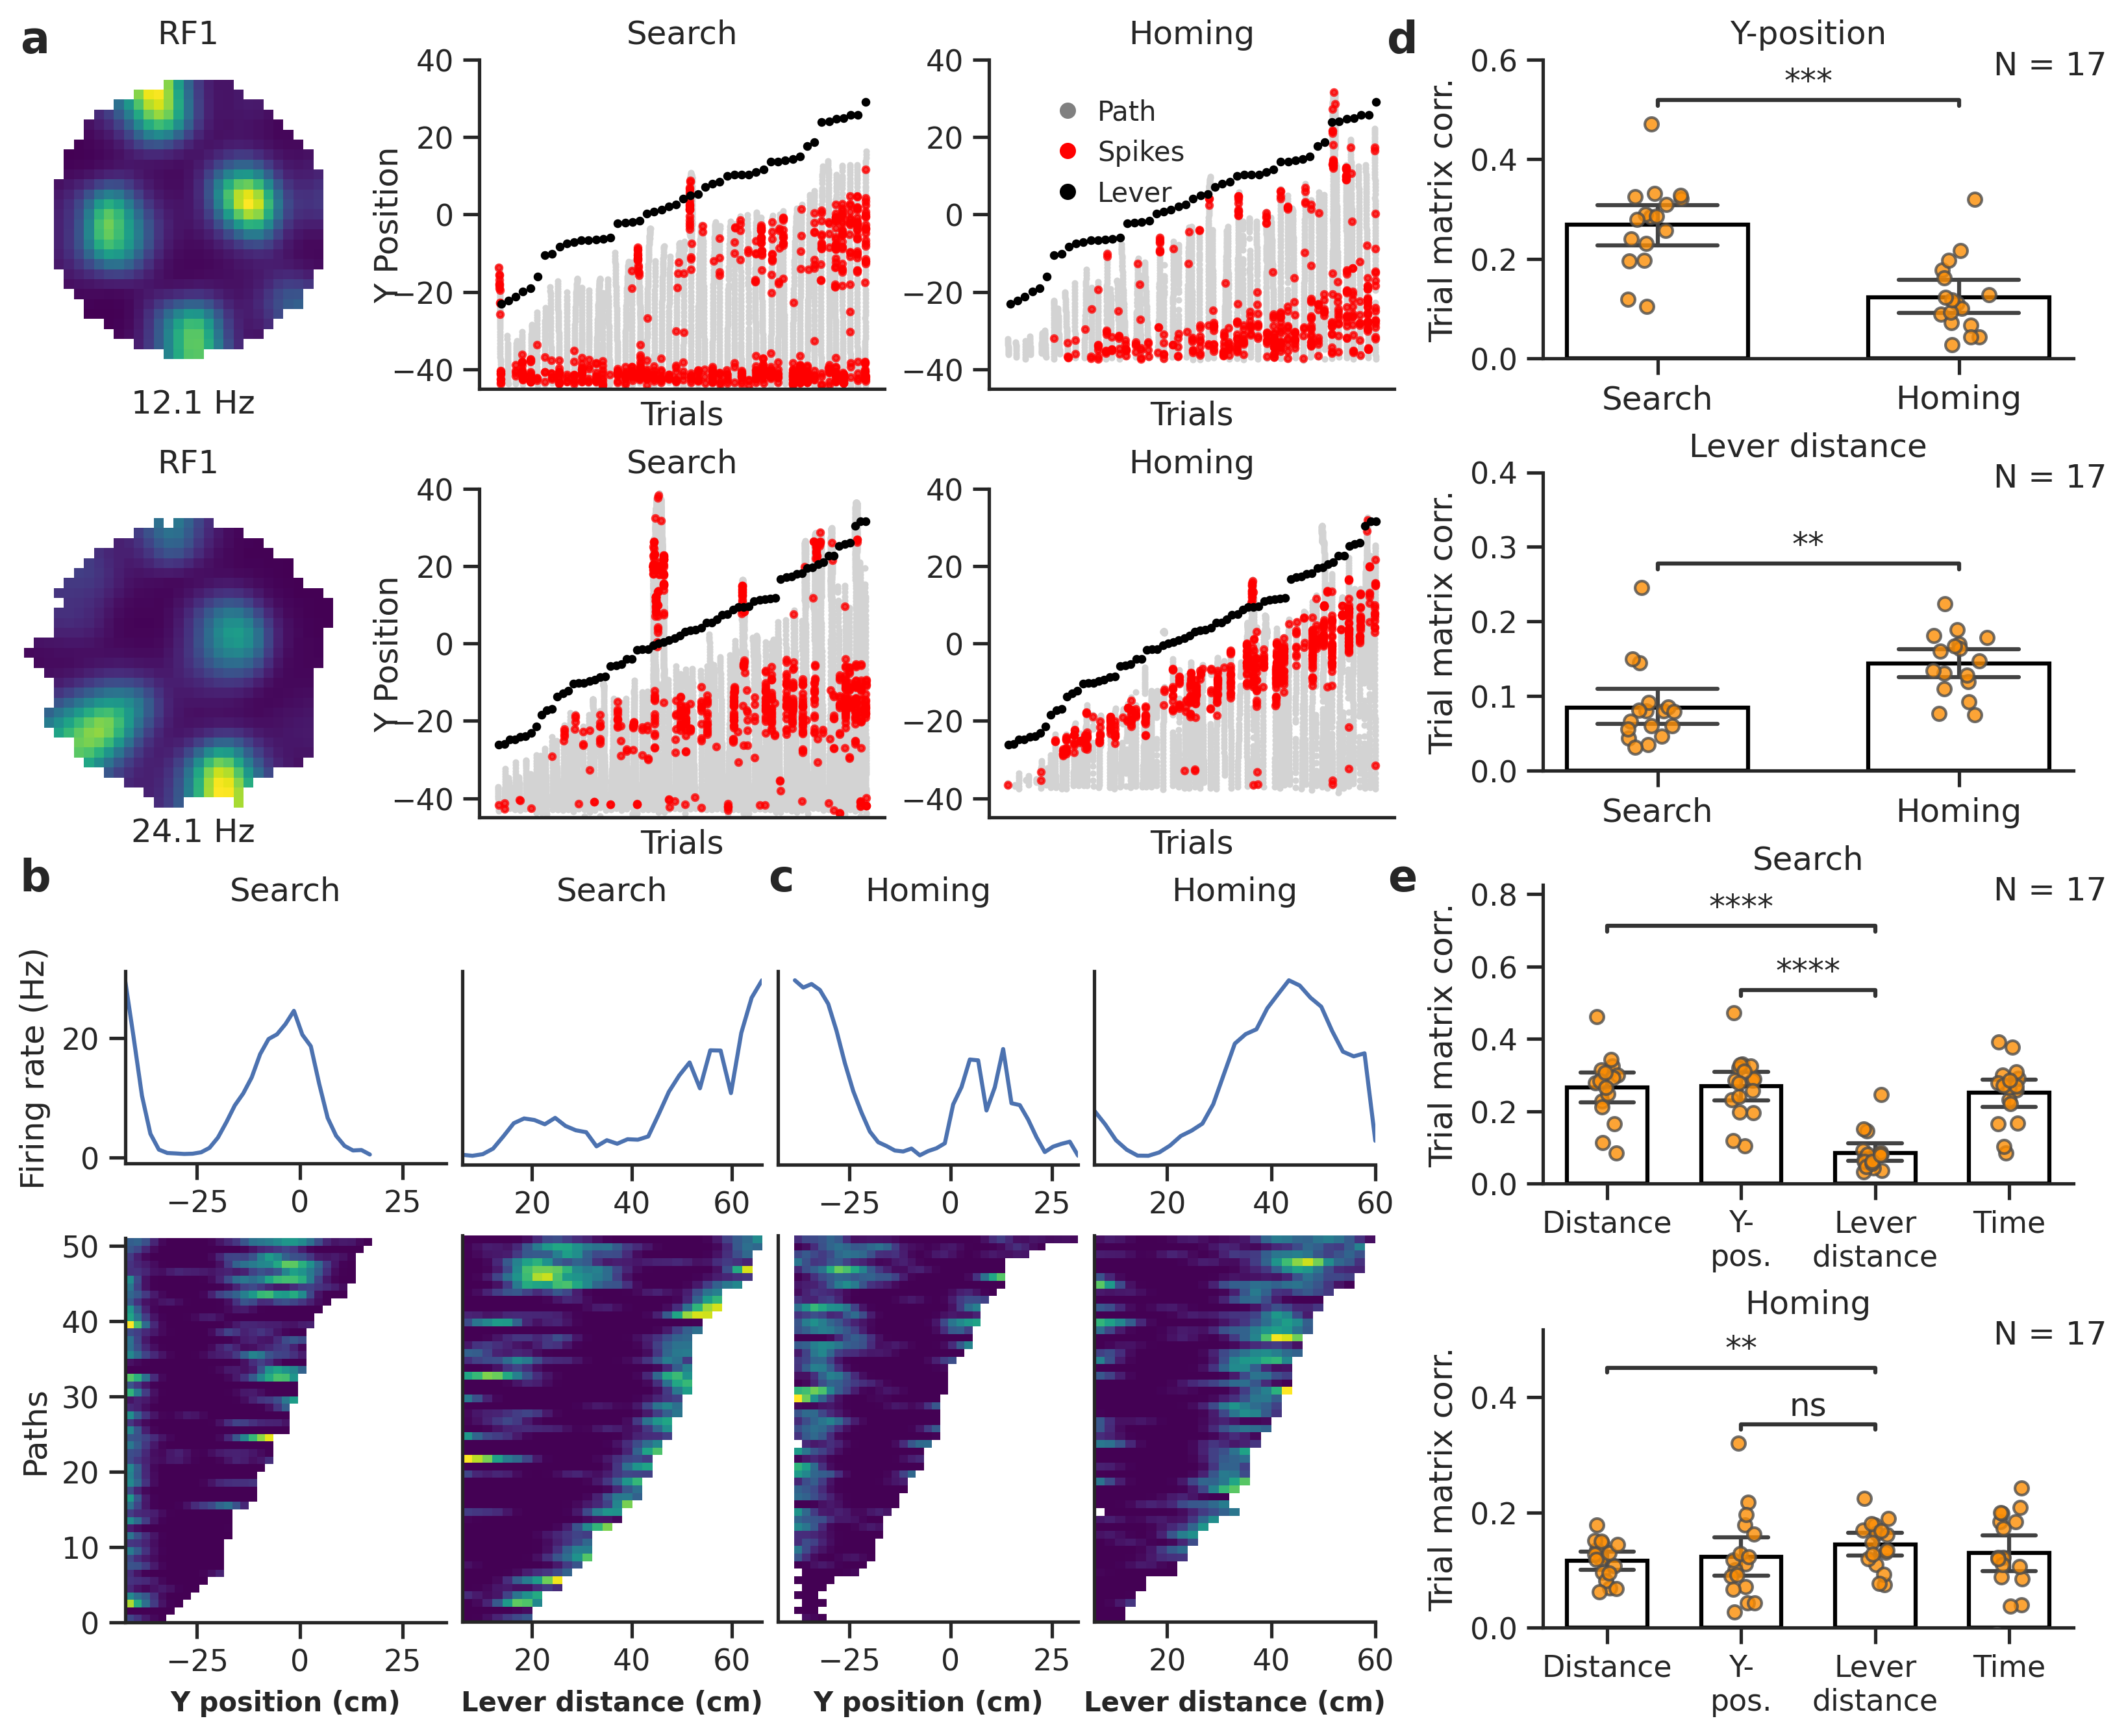

In [52]:
from matplotlib.gridspec import GridSpecFromSubplotSpec
rowSize,colSize= 2.2,1.8
ncols=6
nrows=4
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
gs = fig.add_gridspec(ncols=ncols, nrows=nrows,width_ratios=[1,1,1,1,0.05,2])
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

#Data Used For Making the Plot
sns.set_theme(style = 'ticks')

# NOTE Examples first
gsExamples = GridSpecFromSubplotSpec(2,3,subplot_spec=gs[:2,:4],height_ratios=[1,1],width_ratios=[1,1.2,1.2])

cluId1 = 'jp451-30102022-0108_262'
plot_cell_row_no_lever(gsExamples,0,cluId1,legend=False,ld='light')

cluId2 = 'mn8578-23122021-0108_51'
plot_cell_row_no_lever(gsExamples,1,cluId2,legend=False,ld='light')



# PLot for a first example
gsBottomExamples = GridSpecFromSubplotSpec(1,4,subplot_spec=gs[2:,:4],width_ratios=[1.4,1,1,1])

# Search Y Position
gs_1 = GridSpecFromSubplotSpec(3,1,subplot_spec=gsBottomExamples[0],height_ratios=[0.2,1,2])
m1 = get_matDic(mySearchDict,cluId=cluId1,pathType = "searchToLeverPath", light = "light", var = "y")
plotCombinedHeatmapAndLine(fig,gs_1,m1,sort=True,processMatrix=False)

ax0 = fig.add_subplot(gs_1[0,:])
ax0.set_title('Search',fontsize=GLOBALFONTSIZE)
ax0.axis('off')

# Search Lever Position
gs_1 = GridSpecFromSubplotSpec(3,1,subplot_spec=gsBottomExamples[1],height_ratios=[0.2,1,2])
m1 = get_matDic(mySearchDict,cluId=cluId1,pathType = "searchToLeverPath", light = "light", var = "targetDistance")
plotCombinedHeatmapAndLine(fig,gs_1,m1,sort=True,processMatrix=False,noShowY=True)

ax0 = fig.add_subplot(gs_1[0,:])
ax0.set_title('Search',fontsize=GLOBALFONTSIZE)
ax0.axis('off')

#Homing Y Position
gs_1 = GridSpecFromSubplotSpec(3,1,subplot_spec=gsBottomExamples[2],height_ratios=[0.2,1,2])
m1 = get_matDic(myHomingDict,cluId=cluId1,pathType = "homingFromLeavingLeverToPeriphery", light = "light", var = "y")
plotCombinedHeatmapAndLine(fig,gs_1,m1,sort=True,processMatrix=False,noShowY=True)

ax0 = fig.add_subplot(gs_1[0,:])
ax0.set_title('Homing',fontsize=GLOBALFONTSIZE)
ax0.axis('off')

#Homing Lever Position
gs_1 = GridSpecFromSubplotSpec(3,1,subplot_spec=gsBottomExamples[3],height_ratios=[0.2,1,2])
m1 = get_matDic(myHomingDict,cluId=cluId1,pathType = "homingFromLeavingLeverToPeriphery", light = "light", var = "targetDistance")
plotCombinedHeatmapAndLine(fig,gs_1,m1,sort=True,processMatrix=False,noShowY=True)

ax0 = fig.add_subplot(gs_1[0,:])
ax0.set_title('Homing',fontsize=GLOBALFONTSIZE)
ax0.axis('off')


# NOTE Add stats
gsStats = GridSpecFromSubplotSpec(4,1,subplot_spec=gs[:,5])

ax0=fig.add_subplot(gsStats[0])
plot_behavioral_variable_box_plot_only_light(ax0,grouped_df,varCond='y',title='Y-position',yl=0.6,lightCond='light')

ax0=fig.add_subplot(gsStats[1])
plot_behavioral_variable_box_plot_only_light(ax0,grouped_df,varCond='targetDistance',title='Lever distance',legend=False,lightCond='light')

ax0=fig.add_subplot(gsStats[2])
plot_distance_lever_box_plot_only_light(ax0,grouped_df,pathCond='searchToLeverPath',title='Search',yl=0.8,lightCond='light')

ax0=fig.add_subplot(gsStats[3])
plot_distance_lever_box_plot_only_light(ax0,grouped_df,pathCond='homingFromLeavingLeverToPeriphery',title='Homing',yl=0.4,legend=False,lightCond='light')


# NOTE Add figure legends
gsLegend = GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[:,:])
# #***********************************#
ax0 = fig.add_subplot(gsLegend[:,:])
plot_spike_on_path_legend(ax0, location=(0.52, 0.98))
#Add figure legend
add_text(ax0,0,1,'a',fw='900')
add_text(ax0,0,0.5,'b',fw='900')
add_text(ax0,0.36,0.5,'c',fw='900')

add_text(ax0,0.66,1,'d',fw='900')
add_text(ax0,0.66,0.5,'e',fw='900')
ax0.axis('off')
###

plt.savefig('../../Output/Ext_Figure6.jpg', bbox_inches='tight', dpi=300)